### CAPTURE SATELLITE IMAGES FOR PAST PERIOD WITH LANDSAT-5 (1984 - 2000)

The purpose of all these was to automate the capture of satellites plot's images from the four LFI campaign (1983 -> 2017)...
In reference with the documentation (see [here](docs_and_ref)),
we used two different satellites, LANDSAT 5 and LANDSAT 7. I started with the assumption that to minimize the number of satellite allows us to keep a possible uniformity of the collection...
Thus, LANDSAT 5 (1984 -> 2013) was used for the first three campaigns (LFI1, LFI2, LFI3) and LANDSAT 7 for the last campaign (LFI4).

Here, this notebook is an example of a capture automatization with LANDSAT 5, Collection 2 (better harmonization) , Tiers 1 (Tiers 1 is most stable than Tiers 2 wich contains particular events on the images).

We had to paralelize the acquisition, because each script launch with Google Eart Engine API took about 10-12 hrs, for 10-16 Go of data... We used our four local machine, beacause we didn't have the time and budget to set up another solution (EC2 for example) and it was a "one shot" acquisition. anyway.


This was the notebook version, simply usable by my collaborators on this project with a Docker Jupyter Lab environnement... but I created also a python script version, also stored in this folder.

This script contains a code sample taken from a anonymous author who has a blog : 
https://mygeoblog.com/2019/08/21/google-earth-engine-to-numpy/
(author : thisearthsite - anonymous)

In [1]:
import ee
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import time
from datetime import date
import json
from json import JSONEncoder

Authentication to the Google Earth Engine API:

Click on the link and follow the instructions (with your google account active) to receive the token and copy and paste it into the output code cell.

In [2]:
ee.Authenticate()
ee.Initialize()
print(ee.Image("NASA/NASADEM_HGT/001").get("title").getInfo())


Successfully saved authorization token.
NASADEM: NASA NASADEM Digital Elevation 30m


-----------

IMPORT AND MANAGE DATA :

In [33]:
data = pd.read_excel('DataFrames/data_parcelles_with_gps.xlsx')

In [34]:
data_used = data[['PARCELLE','LAT', 'LON','DATE','LFI']]

Campaign's filter :

In [35]:
LFI = 'LFI3' # exemple

data_used = data_used.loc[data_used['LFI']==LFI,:]

Code for a test on few lines :

In [36]:
data_used = data_used[0:5]
data_used

Code with another type of filter for a problematic list (to relaunch the script a second time from a problematic list of forest plots generated at the first time) :

In [32]:
# pb_list_df = pd.read_csv('Problematic_parcelles_part2bis.csv') #exemple
# pb_list = pb_list_df['Problematic parcelles'].to_list()
# data_used = data_used.loc[data_used['PARCELLE'].isin(pb_list),:]
#len(data_used)

0

--------------------------

CLASS FOR EXCEPTIONS MANAGEMENT :

In [7]:
class NoImage(Exception):
    def __init__(self, nb_image):
        self.__nb_image = nb_image

    @property
    def nb_image(self):
        return self.__nb_image

In [8]:
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, (datetime, date)):
            return str(obj)
        return json.JSONEncoder.default(self, obj)

SPECTRAL BANDS FUNCTIONS (FOR LANDSAT-5 & 7):

In [9]:
def NDVI(img): #repère la végétation tout simplement
    img = ee.Image(img.normalizedDifference(['B4', 'B3'])).rename(["ndvi"])
    return img

def EVI(img): #idem NDVI, plus fiable et fin en théorie
    img = ee.Image(img.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
            'NIR': img.select('B4').divide(10000),
            'RED': img.select('B3').divide(10000),
            'BLUE': img.select('B1').divide(10000)
        })).rename(["evi"])
    
    return img

def NDMI(img): #repère la teneur en eau dans la végétation
    #img = ee.Image(img.normalizedDifference(['B8', 'B11'])).rename(["ndmi"])
    img = ee.Image(img.expression(
        '(NIR - SWITCH) / (SWITCH + NIR)', {
            'NIR': img.select('B4').divide(10000),
            'SWITCH': img.select('B5').divide(10000)
       })).rename(["ndmi"])
    return img

def NDWI(img): #teneur en d'eau en surface
    #img = ee.Image(img.normalizedDifference(['B3', 'B8'])).rename(["ndwi"])
    img = ee.Image(img.expression(
        '(GREEN - NIR) / (GREEN + NIR)', {
            'NIR': img.select('B4').divide(10000),
            'GREEN': img.select('B2').divide(10000)
        })).rename(["ndwi"])
    return img


def DSWI(img): # Disease Water Stress Index sensitive to stress due to water shortage and plant damage
    img = ee.Image(img.expression(
        '(NIR - GREEN) / (SWIR1 + RED)', {
            'NIR': img.select('B4').divide(10000),
            'RED': img.select('B3').divide(10000),
            'GREEN': img.select('B2').divide(10000),
            'SWIR1': img.select('B5').divide(10000),
        })).rename(["dswi"])
    
    return img

def B1(img):
    b2 = ee.Image(img.select(['B1'])).divide(10000).rename(["b1"])
    return b2

def B2(img):
    b2 = ee.Image(img.select(['B2'])).divide(10000).rename(["b2"])
    return b2

def B3(img):
    b3 = ee.Image(img.select(['B3'])).divide(10000).rename(["b3"])
    print('add b3')
    return b3

def B4(img):
    b4 = ee.Image(img.select(['B4'])).divide(10000).rename(["b4"])
    return b4

def B5(img):
    b5 = ee.Image(img.select(['B5'])).divide(10000).rename(["b5"])
    return b5

CONVERSION FUNCTIONS :

This (big) function allows us to make a request to the GEE API with GPS coordinates and return a dictionary with different aggregated images taken from the collection for this place, for each spectral bands function.

In [10]:
def collection_to_array(lat_loc, lon_loc, date_dep, date_fin):
    global dim_image, percentage_max_cloud_cover, Spectral_Band_init, Spectral_Functions, Sattelite
    pas_lat = dim_image/111120 # to convert meters in lattitude and longitude difference
    pas_lon = dim_image/111120

    area = ee.Geometry.BBox(lon_loc - pas_lon/2, lat_loc-pas_lat/2, lon_loc + pas_lon/2, lat_loc + pas_lat/2) # to cut a square equal to the image
    pas_lon_cos = dim_image/(111120 * np.cos(lat_loc*np.pi/180)) # correction metrics with longitude and lattitude as a parameter
    area_cos = ee.Geometry.BBox(lon_loc - pas_lon_cos/2, lat_loc-pas_lat/2, lon_loc + pas_lon_cos/2, lat_loc + pas_lat/2)

    # images collection
    collection = ee.ImageCollection(Sattelite).filterBounds(area_cos) \
                                      .filterDate(date_dep,date_fin) \
                                      #.filterMetadata("CLOUDY_PIXEL_PERCENTAGE","less_than",percentage_max_cloud_cover)\
                                      #.select(Spectral_Band_init) \
                                      
                                      
    print('collection')
    nb_images = collection.size().getInfo()
    print(f'{nb_images} images founded...')

    if nb_images == 0:
        raise NoImage(nb_images)


    # images conversion (in np array)

    im_dict = dict()

    
    for _, funct in enumerate(Spectral_Functions):

    # with a collection of images taken from one place, we make a loop for each spectral band function...
        
    ### This lines of code were adapted from a version taken from
    #  https://mygeoblog.com/2019/08/21/google-earth-engine-to-numpy/ (author : thisearthsite - anonymous) ###
    ### START ###
        myCollection  = collection.map(Spectral_Functions.get(funct)) # filter by the spectral band function
        img = ee.Image(myCollection.mean()).rename(['result']) # a mean aggregation with all images
        img = img.addBands(ee.Image.pixelLonLat()) # ad a Longitude / Lattitude channnel
        img = img.reduceRegion(reducer=ee.Reducer.toList(),\
                                        geometry=area,\
                                        maxPixels=1e8,\
                                        scale=1) # define a good square for the image

        data = np.array((ee.Array(img.get('result')).getInfo()))
        lats = np.array((ee.Array(img.get("latitude")).getInfo()))
        lons = np.array((ee.Array(img.get("longitude")).getInfo()))
        uniqueLats = np.unique(lats)
        uniqueLons = np.unique(lons)
        ncols = len(uniqueLons)
        nrows = len(uniqueLats)
        arr = np.zeros([nrows, ncols], np.float32)
        counter =0
        for y in range(0,len(arr),1):
            for x in range(0,len(arr[0]),1):
                if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                    counter+=1
                    arr[len(uniqueLats)-1-y,x] = data[counter]
        
    ### END ###
        im_dict[f'{funct}'] = arr # write array result in the functions dictionary

        if funct==NDVI:
            im_dict[f'TNDVI'] = np.sqrt(arr) + 0.5 # add a normalized NDVI function (it's a bonus)
    
    return im_dict # to return all the dictionnary for all the spectral bands functions
    

--------------

USER'S PARAMETERS :

In [37]:
Sattelite = 'LANDSAT/LT05/C02/T1'

dim_image = 200 #mètres de côté

OTHER PARAMETERS :

In [12]:
#percentage_max_cloud_cover = 100

Spectral bands requirements (if you want to minimize it):

In [37]:
#Spectral_Band_init = ['B2', 'B3', 'B4', 'B5']

Spectral functions in outputs :

Notes : Spectral's bands from above are ingredients for functions below... be attentive : keeping the dictionnary format

In [12]:
Spectral_Functions = {'NDVI':NDVI, 'EVI':EVI, 'NDMI':NDMI, 'NDWI':NDWI, 'DSWI':DSWI}

Half Time opening in days (centered on June 30) :

The collection of images will be done between "date - days" and "date + days" ... so, if days = 10, Time opening = 20...

If the program has difficulties to collect an image with this Time opening, it will try automatically with Time opening X 2, then, Time opening X 4...

In [13]:
days = 25

------------

IMAGES CAPTURE :

The main program wich automate the collection capture for each forest's plot... and write it in a big json dictionnary file.

In [38]:
# here, we take the year of the forest's plot field records, because the API request will be sent with the June 30 of this year, for each plot...
data_lfi = data_used
data_lfi['YEAR'] = data_lfi['DATE'].map(lambda d : d.year)

# here, we need to "cheat" with the 1983 year (because LANDSAT 5 was launched in 1984)...
if LFI=='LFI1':
    data_lfi['YEAR'] = data_lfi['YEAR'].map(lambda d: 1984 if d==1983 else d)
print (f"For campaign {LFI}, all the images will be extracted for this years : {data_lfi['YEAR'].unique()}...")


# --- FORCE TEST YEAR --- 
#data_lfi['YEAR'] = 1990

#data_lfi = data_lfi[0:5]

# --- END TEST ---

nb_lines = len(data_lfi)
matrix_data = np.matrix(data_lfi) # to convert dataframe into a matrix array (best computing time)

Stock_images_list =dict() # to prepare the images result list
Problem_list = []

for i in range(nb_lines):

    deb_image = time.time()

    # preprocessing
    # for each forest plot, defining variables for the function "collection to array" function
    parc_name = matrix_data.item(i, 0)
    print(f'--- PARCELLE {matrix_data.item(i, 0)} ---')
    parc_dict=dict()
    date_image = datetime.datetime.strptime(str(matrix_data.item(i, 5)) + '-06-30', '%Y-%m-%d')
    date_dep = (date_image - datetime.timedelta(days=days))
    date_fin = (date_image + datetime.timedelta(days=days))
    date_dep_string = str(date_dep.year) + '-' + str(date_dep.month) + '-' + str(date_dep.day)
    date_fin_string = str(date_fin.year) + '-' + str(date_fin.month) + '-' + str(date_fin.day)
    lat_loc = matrix_data.item(i, 1)
    lon_loc = matrix_data.item(i, 2)

    try:
        # api request and collection capture
        dict_images = collection_to_array(lat_loc, lon_loc, date_dep, date_fin)

    except NoImage:
        date_dep -= datetime.timedelta(days=days)
        date_fin += datetime.timedelta(days=days)
        print(f'Zéro images for parcelle {parc_name}... so we tried with a days open of {days*4} days...')

        try:
            dict_images = collection_to_array(lat_loc, lon_loc, date_dep, date_fin)

        except NoImage:
            date_dep -= datetime.timedelta(days=days)
            date_fin += datetime.timedelta(days=days)
            print(f'Zéro images for parcelle {parc_name}... so we tried with a days open of {days*8} days...')

            try:
                dict_images = collection_to_array(lat_loc, lon_loc, date_dep, date_fin)

            except:
                print(f'--- PROBLEM ! with parcelle {parc_name}... ---')
                dict_images = np.nan
                Problem_list.append(parc_name)
        except:
            print(f'--- PROBLEM ! with parcelle {parc_name}... ---')
            dict_images = np.nan
            Problem_list.append(parc_name)
    except:
        print(f'--- PROBLEM ! with parcelle {parc_name}... ---')
        dict_images = np.nan
        Problem_list.append(parc_name)

    # Writing results from the matrix array to the dictionnary result
    parc_dict['PARCELLE'] = matrix_data.item(i, 0)
    parc_dict['LAT, LON'] = (lat_loc, lon_loc)
    parc_dict['DATE_INIT'] = str(matrix_data.item(i, 3))
    parc_dict['LFI'] = matrix_data.item(i, 4)
    parc_dict['DATE_IMAGE_SAT'] = str(date_image)
    parc_dict['IMAGES_SAT'] = dict_images
    Stock_images_list[f'{matrix_data.item(i, 0)}'] = parc_dict
    fin_image = time.time()
    print(f'This image traitment took {round(fin_image - deb_image,4)} seconds... ')

print('Finish !...')
print(f'But we have a problem with this list of parcelles : {Problem_list}')


For campaign LFI3, all the images will be extracted for this years : [2005 2004]...
--- PARCELLE 51 ---
collection
4 images founded...
This image traitment took 24.425 seconds... 
--- PARCELLE 384 ---
collection
4 images founded...
This image traitment took 17.2935 seconds... 
--- PARCELLE 1239 ---
collection
6 images founded...
This image traitment took 20.2053 seconds... 
--- PARCELLE 1419 ---
collection
6 images founded...
This image traitment took 21.3735 seconds... 
--- PARCELLE 1431 ---
collection
6 images founded...
This image traitment took 17.2741 seconds... 
Finish !...
But we have a problem with this list of parcelles : []


---------------

#### EXPORTS

option 1 : export in slicing mode (to prevent bugs):

In [15]:
nb_parts = 8 # to define number of parts of the unique dict

In [16]:
Decoup_stock_images = []

len_sub_list = len(Stock_images_list)//nb_parts

for i in range(nb_parts-1):
    Decoup_stock_images.append(dict(list(Stock_images_list.items())[i*len_sub_list:(i+1)*len_sub_list]))
Decoup_stock_images.append(dict(list(Stock_images_list.items())[(nb_parts-1)*len_sub_list:]))

In [17]:
for i in range(nb_parts):
    print(f'... Exportation of dict n°{i} (lenght : {len(Decoup_stock_images[i])}) in a jsonfile...')
    list_json = json.dumps(Decoup_stock_images[i], cls=NumpyArrayEncoder)
    with open(f"Results_Images_Stock/Images_{Sattelite.split('/')[0].split('-')[0]}_{LFI}_part{i+1}.json", "w") as outfile:
        outfile.write(list_json)
    print(f'... Exportation dict n°{i} done...')

... Exportation of dict n°0 (lenght : 0) in a jsonfile...
... Exportation dict n°0 done...
... Exportation of dict n°1 (lenght : 0) in a jsonfile...
... Exportation dict n°1 done...
... Exportation of dict n°2 (lenght : 0) in a jsonfile...
... Exportation dict n°2 done...
... Exportation of dict n°3 (lenght : 0) in a jsonfile...
... Exportation dict n°3 done...
... Exportation of dict n°4 (lenght : 0) in a jsonfile...
... Exportation dict n°4 done...
... Exportation of dict n°5 (lenght : 0) in a jsonfile...
... Exportation dict n°5 done...
... Exportation of dict n°6 (lenght : 0) in a jsonfile...
... Exportation dict n°6 done...
... Exportation of dict n°7 (lenght : 4) in a jsonfile...
... Exportation dict n°7 done...


option 2 : Export in a unique json file :

In [39]:
print('... Exportation in a jsonfile...')

list_json = json.dumps(Stock_images_list, cls=NumpyArrayEncoder)
with open(f"Results_Images_Stock/Images_{Sattelite.split('/')[0].split('-')[0]}_{LFI}_pb2.json", "w") as outfile:
    outfile.write(list_json)

print('... Exportation done...')



... Exportation in a jsonfile...
... Exportation done...


Export of the problematic list :

In [24]:
print('... Exportation of the problematic parcelle\'s list in a text...')

df_pb_list = pd.DataFrame(Problem_list, columns=['Problematic parcelles'])
df_pb_list.to_csv('Problematic_parcelles_part2bis.csv')

print('...Exportation done...')

... Exportation of the problematic parcelle's list in a text...
...Exportation done...


---------------

To test a file opening and display images collection for a forest plot :

In [40]:
with open(f"Results_Images_Stock/Images_{Sattelite.split('/')[0].split('-')[0]}_{LFI}_pb2.json", 'r') as openfile:
 
    json_object = json.load(openfile)

In [42]:
json_object['51'].get('DATE_INIT')

'2005-11-01 00:00:00'

In [43]:
json_object['51'].get('DATE_IMAGE_SAT')

'2005-06-30 00:00:00'

In [44]:
json_object['51'].get('LAT, LON')

[47.78162341651316, 8.612821767035694]

In [45]:
data_lfi[0:5]

,PARCELLE,LAT,LON,DATE,LFI,YEAR
3,51,47.781623,8.612822,2005-11-01,LFI3,2005
6,384,47.736528,8.625154,2005-10-26,LFI3,2005
11,1239,47.668637,9.036432,2004-10-28,LFI3,2004
15,1419,47.660188,8.996234,2004-10-27,LFI3,2004
18,1431,47.659089,9.076087,2004-10-25,LFI3,2004


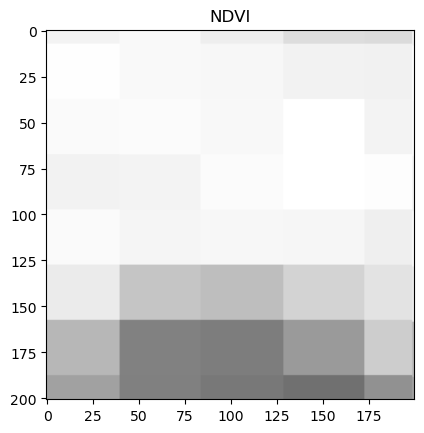

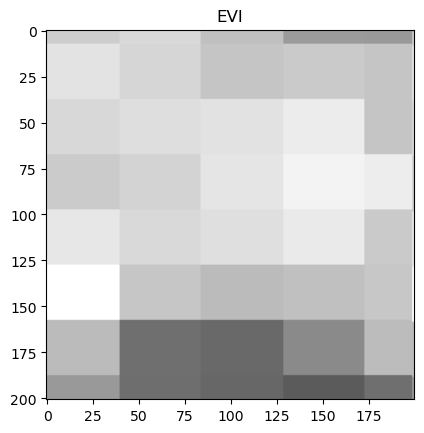

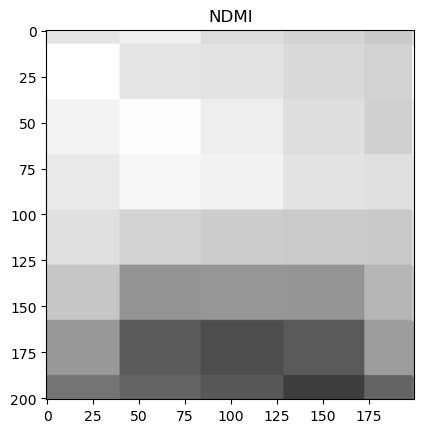

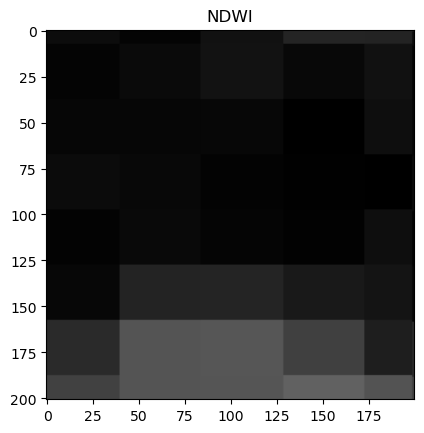

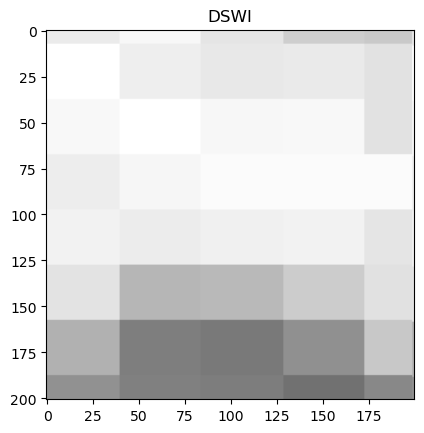

In [47]:
for _, funct in enumerate(json_object['1239'].get('IMAGES_SAT')):
    plt.title(f'{funct}')
    plt.imshow(json_object['1239'].get('IMAGES_SAT').get(funct), 'gray')
    plt.show()